# VoxelMorph

A playground to have fun in

In [2]:
from __future__ import annotations
from collections import defaultdict
from importlib import reload
import matplotlib.pyplot as plt; plt.style.use('seaborn-pastel'); plt.set_cmap('bone')
import neurite as ne
import numpy as np
import os; os.environ['VXM_BACKEND'] = 'pytorch'
from pathlib import Path
import sys
from time import perf_counter
import torch
import torchvision
from tqdm import tqdm 
import random
import voxelmorph as vm
print(sys.version)
print('numpy version', np.__version__)
print('torch version', torch.__version__)
print(f'voxelmorph using {vm.py.utils.get_backend()} backend')

2022-05-05 02:18:41.952139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-05 02:18:41.952178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
numpy version 1.21.2
torch version 1.11.0
voxelmorph using pytorch backend


<Figure size 432x288 with 0 Axes>

## data

### datasets

* [mnist](https://pytorch.org/vision/stable/datasets.html)
* [fashionmnist](https://pytorch.org/vision/stable/datasets.html)
* [omniglot](https://pytorch.org/vision/stable/datasets.html)
* [morphomnist](https://github.com/dccastro/Morpho-MNIST)
* [caltech 101 silhouettes](https://people.cs.umass.edu/~marlin/data.shtml)

In [3]:
data_dir = Path('datasets')
data_dir.mkdir(exist_ok=True)

In [4]:
mnist_dir = data_dir / 'mnist'
mnist_dir.mkdir(exist_ok=True)
mnist = torchvision.datasets.MNIST(root=mnist_dir, download=True)

fashionmnist_dir = data_dir / 'fashionmnist'
fashionmnist_dir.mkdir(exist_ok=True)
fashionmnist = torchvision.datasets.FashionMNIST(root=fashionmnist_dir, download=True)

omniglot_dir = data_dir / 'omniglot'
omniglot_dir.mkdir(exist_ok=True)
omniglot = torchvision.datasets.Omniglot(root=omniglot_dir, download=True)

Files already downloaded and verified


### partition by class

In [5]:
def filter_by_class(data, labels, class_to_keep: int = 0):
    indexer = labels == class_to_keep
    filtered_data = data[indexer]
    filtered_labels = labels[indexer]
    return filtered_data, filtered_labels

def partition_by_class(data, labels, classes):
    class_partitions = {}
    for k in classes:
        class_partitions[k] = filter_by_class(data, labels, k)
    return class_partitions
       

In [6]:
mnist_data = mnist.data.numpy()
mnist_labels = mnist.targets.numpy()
mnist_classes = np.unique(mnist_labels)
mnist_partitions = partition_by_class(mnist_data, mnist_labels, mnist_classes)

In [7]:
fashionmnist_data = fashionmnist.data.numpy()
fashionmnist_labels = fashionmnist.targets.numpy()
fashionmnist_classes = np.unique(fashionmnist_labels)
fashionmnist_partitions = partition_by_class(fashionmnist_data, fashionmnist_labels, fashionmnist_classes)

### split data

In [8]:
def get_data_split(data, labels, val_split=0.1, test_split=0.2):
    data = np.asarray(data)
    labels = np.asarray(labels)
    n = data.shape[0]
    assert n == labels.shape[0]
    index = list(range(n))
    random.shuffle(index)
    num_test = round(test_split * n)
    num_dev = n - num_test
    num_val = round(num_dev * val_split)
    num_train = num_dev - num_val
    train_index = index[:num_train]
    val_index = index[num_train:num_train+num_val]
    test_index = index[-num_test:]
    return {
        'train_data': data[train_index],
        'train_labels': labels[train_index],
        'val_data': data[val_index],
        'val_labels': labels[val_index],
        'test_data': data[test_index],
        'test_labels': labels[test_index],
    }

### choose class

In [9]:
three_data = mnist_partitions[3]
three_split = get_data_split(*three_data)

five_data = mnist_partitions[5]
five_split = get_data_split(*five_data)

In [10]:
sandal_data = fashionmnist_partitions[5]
sandal_split = get_data_split(*sandal_data)

sneaker_data = fashionmnist_partitions[7]
sneaker_split = get_data_split(*sneaker_data)

boot_data = fashionmnist_partitions[9]
boot_split = get_data_split(*boot_data)

### dataset class

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        data: np.ndarray, 
        labels: np.ndarray, 
        normalize: bool = True,
        padding: None | tuple[int, int] = (32, 32), 
        transforms: None | list[torchvision.transforms] = [
            # torchvision.transforms.Pad((32, 32), fill=0),
            torchvision.transforms.ToTensor(),
        ],
    ):
        self.data = data
        self.labels = labels
        self.normalize = normalize
        self.padding = padding
        self.transforms = torchvision.transforms.Compose(transforms)

    def __len__(self):
        return self.data.shape[0] - 1

    def __getitem__(self, index):
        moving_image = self.data[index]
        fixed_image = self.data[index+1]
        if self.transforms:
            moving_image = self.transforms(moving_image)
            fixed_image = self.transforms(fixed_image)
        if self.padding:
            moving_image = self.pad(moving_image)
            fixed_image = self.pad(fixed_image)
            
        return torch.cat([moving_image, fixed_image], 0)
    
    def normalize(self, image):
        pass
    
    def pad(self, image):
        # only handles case when pad > size
        w, h = image.squeeze().shape
        assert self.padding[0] >= w, 'width padding too small'
        assert self.padding[1] >= h, 'height padding too small'
        w_diff = self.padding[0] - w
        h_diff = self.padding[1] - h
        w_pad = w_diff // 2
        h_pad = h_diff // 2
        padding = w_pad, w_diff - w_pad, h_pad, h_diff - h_pad
        image = torch.nn.functional.pad(image, padding, 'constant', 0)
        return image

In [12]:
def make_datasets(data_split):
    train_dataset = Dataset(data_split['train_data'], data_split['train_labels'])
    val_dataset = Dataset(data_split['val_data'], data_split['val_labels'])
    test_dataset = Dataset(data_split['test_data'], data_split['test_labels'])
    return train_dataset, val_dataset, test_dataset

def show(images):
    number_of_images = len(images)
    fig, ax = plt.subplots(ncols=number_of_images)
    for i in range(number_of_images):
        ax[i].imshow(images[i])
    plt.show()

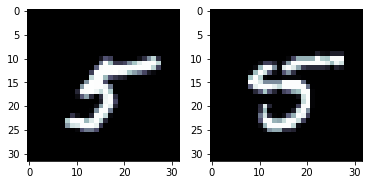

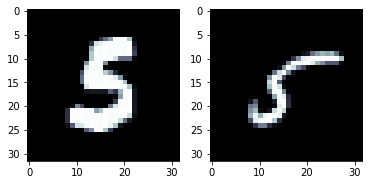

In [13]:
five_train_dataset, five_val_dataset, five_test_dataset = make_datasets(five_split)

show(five_train_dataset[0])
show(five_val_dataset[0])

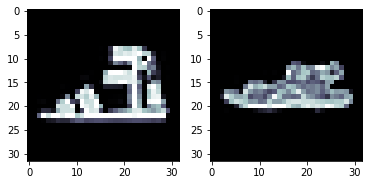

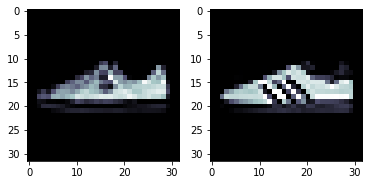

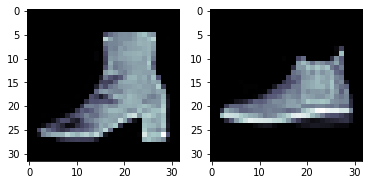

In [14]:
sandal_train_dataset, sandal_val_dataset, sandal_test_dataset = make_datasets(sandal_split)
sneaker_train_dataset, sneaker_val_dataset, sneaker_test_dataset = make_datasets(sneaker_split)
boot_train_dataset, boot_val_dataset, boot_test_dataset = make_datasets(boot_split)

show(sandal_train_dataset[0])
show(sneaker_train_dataset[0])
show(boot_train_dataset[0])

### select dataset

In [15]:
train_dataset = sneaker_train_dataset
val_dataset = sneaker_val_dataset
test_dataset = sneaker_test_dataset

### dataloaders

In [16]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    batch_size: int=32,
    shuffle=True,
    pin_memory=True,
):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        pin_memory=pin_memory,
    )

In [17]:
train_loader = get_dataloader(train_dataset)
val_loader = get_dataloader(val_dataset)
test_loader = get_dataloader(test_dataset, shuffle=False)

In [24]:
img = next(iter(train_loader))
print(img.shape)

torch.Size([32, 2, 32, 32])


## build model

In [18]:
class Model(torch.nn.Module):
    def __init__(
        self,
        image_size: tuple[int, int] | tuple[int, int, int],
        input_channels: int = 2,
    ):
        super().__init__()
        self.image_size = image_size
        self.input_channels= input_channels
        self.ndim = len(image_size)
        self.unet = vm.networks.Unet(inshape=image_size, infeats=input_channels)
        self.flow = getattr(torch.nn, f'Conv{self.ndim}d')(16, 2, 3, padding=1)
        self.relu = torch.nn.LeakyReLU(0.2)
        self.spatial_transformer = vm.layers.SpatialTransformer(image_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        displacement = self.relu(self.flow(self.unet(x)))
        moving_image = x[:, 0].unsqueeze(1)
        moved_image = self.spatial_transformer(moving_image, displacement)
        return moved_image, displacement

In [19]:
inshape = (32, 32)
infeats = 2
model = Model((32, 32)).to('cuda')

/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### loss function

In [20]:
mse = vm.losses.MSE()
grad = vm.losses.Grad('l2')

def loss_func(moving, fixed, displacement, weight=0.05):
    mse_loss = mse.loss(fixed, moving)
    grad_loss = grad.loss(displacement)
    return mse_loss + weight * grad_loss

In [25]:

img = img.to('cuda')
moved, displacement = model(img)
moving_image = img[:, 0].unsqueeze(1)
fixed_image = img[:, 1].unsqueeze(1)
loss = loss_func(moved, fixed_image, displacement)
print(loss)

tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


## training

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [27]:
def iterate(
    model,
    loader,
    training: bool = True,
):
    average_loss = 0.
    for i, images in tqdm(enumerate(loader)):
        moved_images, displacements = model(images.to('cuda'))
        fixed_images = images[:, 1].unsqueeze(1).to('cuda')
        loss = loss_func(moved_images, fixed_images, displacements)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        average_loss += loss.detach().item()
    return average_loss / len(loader)
    

def train(
    model,
    train_loader,
    val_loader,
    epochs: int = 10,
):
    epoch_loss = defaultdict(list)
    for i in range(epochs):
        train_loss = iterate(model, train_loader)
        val_loss = iterate(model, val_loader, training=False)
        epoch_loss['train'].append(train_loss)
        epoch_loss['val'].append(val_loss)
        print(f'epoch {i} finished')
    return epoch_loss

In [30]:
epoch_loss = train(model, train_loader, val_loader, epochs=100)

135it [00:01, 96.20it/s]
15it [00:00, 197.57it/s]


epoch 0 finished


135it [00:01, 101.67it/s]
15it [00:00, 202.57it/s]


epoch 1 finished


135it [00:01, 97.24it/s]
15it [00:00, 207.21it/s]


epoch 2 finished


135it [00:01, 101.80it/s]
15it [00:00, 209.81it/s]


epoch 3 finished


135it [00:01, 100.53it/s]
15it [00:00, 195.91it/s]


epoch 4 finished


135it [00:01, 99.34it/s]
15it [00:00, 211.01it/s]


epoch 5 finished


135it [00:01, 99.14it/s] 
15it [00:00, 209.63it/s]


epoch 6 finished


135it [00:01, 101.22it/s]
15it [00:00, 211.27it/s]


epoch 7 finished


135it [00:01, 101.25it/s]
15it [00:00, 210.44it/s]


epoch 8 finished


135it [00:01, 100.13it/s]
15it [00:00, 194.50it/s]


epoch 9 finished


135it [00:01, 101.44it/s]
15it [00:00, 211.02it/s]


epoch 10 finished


135it [00:01, 102.00it/s]
15it [00:00, 209.61it/s]


epoch 11 finished


135it [00:01, 102.16it/s]
15it [00:00, 210.81it/s]


epoch 12 finished


135it [00:01, 102.20it/s]
15it [00:00, 210.84it/s]


epoch 13 finished


135it [00:01, 101.95it/s]
15it [00:00, 209.22it/s]


epoch 14 finished


135it [00:01, 102.15it/s]
15it [00:00, 210.47it/s]


epoch 15 finished


135it [00:01, 102.30it/s]
15it [00:00, 211.98it/s]


epoch 16 finished


135it [00:01, 102.55it/s]
15it [00:00, 210.62it/s]


epoch 17 finished


135it [00:01, 101.98it/s]
15it [00:00, 211.95it/s]


epoch 18 finished


135it [00:01, 102.03it/s]
15it [00:00, 209.84it/s]


epoch 19 finished


135it [00:01, 102.21it/s]
15it [00:00, 210.14it/s]


epoch 20 finished


135it [00:01, 102.18it/s]
15it [00:00, 210.53it/s]


epoch 21 finished


135it [00:01, 102.00it/s]
15it [00:00, 213.63it/s]


epoch 22 finished


135it [00:01, 102.77it/s]
15it [00:00, 212.45it/s]


epoch 23 finished


135it [00:01, 102.72it/s]
15it [00:00, 212.71it/s]


epoch 24 finished


135it [00:01, 102.26it/s]
15it [00:00, 213.77it/s]


epoch 25 finished


135it [00:01, 102.67it/s]
15it [00:00, 212.80it/s]


epoch 26 finished


135it [00:01, 102.73it/s]
15it [00:00, 213.48it/s]


epoch 27 finished


135it [00:01, 102.69it/s]
15it [00:00, 213.41it/s]


epoch 28 finished


135it [00:01, 102.85it/s]
15it [00:00, 213.72it/s]


epoch 29 finished


135it [00:01, 102.58it/s]
15it [00:00, 211.92it/s]


epoch 30 finished


135it [00:01, 102.23it/s]
15it [00:00, 210.34it/s]


epoch 31 finished


135it [00:01, 102.68it/s]
15it [00:00, 213.71it/s]


epoch 32 finished


135it [00:01, 102.65it/s]
15it [00:00, 213.37it/s]


epoch 33 finished


135it [00:01, 102.59it/s]
15it [00:00, 213.18it/s]


epoch 34 finished


135it [00:01, 102.74it/s]
15it [00:00, 213.65it/s]


epoch 35 finished


135it [00:01, 102.62it/s]
15it [00:00, 213.85it/s]


epoch 36 finished


135it [00:01, 102.66it/s]
15it [00:00, 213.47it/s]


epoch 37 finished


135it [00:01, 102.61it/s]
15it [00:00, 213.69it/s]


epoch 38 finished


135it [00:01, 102.26it/s]
15it [00:00, 213.95it/s]


epoch 39 finished


135it [00:01, 102.07it/s]
15it [00:00, 209.47it/s]


epoch 40 finished


135it [00:01, 102.03it/s]
15it [00:00, 210.09it/s]


epoch 41 finished


135it [00:01, 102.01it/s]
15it [00:00, 210.83it/s]


epoch 42 finished


135it [00:01, 101.26it/s]
15it [00:00, 209.30it/s]


epoch 43 finished


135it [00:01, 97.54it/s]
15it [00:00, 195.78it/s]


epoch 44 finished


135it [00:01, 101.65it/s]
15it [00:00, 209.86it/s]


epoch 45 finished


135it [00:01, 102.12it/s]
15it [00:00, 210.60it/s]


epoch 46 finished


135it [00:01, 102.15it/s]
15it [00:00, 210.65it/s]


epoch 47 finished


135it [00:01, 101.98it/s]
15it [00:00, 210.11it/s]


epoch 48 finished


135it [00:01, 101.98it/s]
15it [00:00, 210.30it/s]


epoch 49 finished


135it [00:01, 101.94it/s]
15it [00:00, 209.95it/s]


epoch 50 finished


135it [00:01, 102.06it/s]
15it [00:00, 210.67it/s]


epoch 51 finished


135it [00:01, 101.77it/s]
15it [00:00, 210.67it/s]


epoch 52 finished


135it [00:01, 102.10it/s]
15it [00:00, 210.83it/s]


epoch 53 finished


135it [00:01, 101.87it/s]
15it [00:00, 210.66it/s]


epoch 54 finished


135it [00:01, 101.90it/s]
15it [00:00, 211.07it/s]


epoch 55 finished


135it [00:01, 101.96it/s]
15it [00:00, 210.91it/s]


epoch 56 finished


135it [00:01, 101.72it/s]
15it [00:00, 210.36it/s]


epoch 57 finished


135it [00:01, 102.00it/s]
15it [00:00, 210.37it/s]


epoch 58 finished


135it [00:01, 101.88it/s]
15it [00:00, 210.39it/s]


epoch 59 finished


135it [00:01, 101.81it/s]
15it [00:00, 210.43it/s]


epoch 60 finished


135it [00:01, 101.71it/s]
15it [00:00, 210.68it/s]


epoch 61 finished


135it [00:01, 101.89it/s]
15it [00:00, 209.69it/s]


epoch 62 finished


135it [00:01, 101.82it/s]
15it [00:00, 210.00it/s]


epoch 63 finished


135it [00:01, 101.70it/s]
15it [00:00, 209.91it/s]


epoch 64 finished


135it [00:01, 101.54it/s]
15it [00:00, 209.40it/s]


epoch 65 finished


135it [00:01, 101.82it/s]
15it [00:00, 210.05it/s]


epoch 66 finished


135it [00:01, 101.77it/s]
15it [00:00, 210.17it/s]


epoch 67 finished


135it [00:01, 101.71it/s]
15it [00:00, 210.40it/s]


epoch 68 finished


135it [00:01, 101.78it/s]
15it [00:00, 209.95it/s]


epoch 69 finished


135it [00:01, 101.56it/s]
15it [00:00, 211.33it/s]


epoch 70 finished


135it [00:01, 101.93it/s]
15it [00:00, 211.03it/s]


epoch 71 finished


135it [00:01, 101.88it/s]
15it [00:00, 209.92it/s]


epoch 72 finished


135it [00:01, 102.00it/s]
15it [00:00, 210.64it/s]


epoch 73 finished


135it [00:01, 101.78it/s]
15it [00:00, 210.01it/s]


epoch 74 finished


135it [00:01, 101.78it/s]
15it [00:00, 210.52it/s]


epoch 75 finished


135it [00:01, 101.73it/s]
15it [00:00, 210.68it/s]


epoch 76 finished


135it [00:01, 101.71it/s]
15it [00:00, 210.38it/s]


epoch 77 finished


135it [00:01, 101.20it/s]
15it [00:00, 209.69it/s]


epoch 78 finished


135it [00:01, 101.52it/s]
15it [00:00, 210.09it/s]


epoch 79 finished


135it [00:01, 101.74it/s]
15it [00:00, 209.68it/s]


epoch 80 finished


135it [00:01, 100.54it/s]
15it [00:00, 209.45it/s]


epoch 81 finished


135it [00:01, 101.38it/s]
15it [00:00, 210.21it/s]


epoch 82 finished


135it [00:01, 101.61it/s]
15it [00:00, 210.66it/s]


epoch 83 finished


135it [00:01, 101.52it/s]
15it [00:00, 209.85it/s]


epoch 84 finished


135it [00:01, 101.70it/s]
15it [00:00, 210.22it/s]


epoch 85 finished


135it [00:01, 101.16it/s]
15it [00:00, 209.58it/s]


epoch 86 finished


135it [00:01, 101.35it/s]
15it [00:00, 210.03it/s]


epoch 87 finished


135it [00:01, 101.57it/s]
15it [00:00, 209.10it/s]


epoch 88 finished


135it [00:01, 101.08it/s]
15it [00:00, 209.65it/s]


epoch 89 finished


135it [00:01, 101.02it/s]
15it [00:00, 209.82it/s]


epoch 90 finished


135it [00:01, 100.81it/s]
15it [00:00, 210.00it/s]


epoch 91 finished


135it [00:01, 100.98it/s]
15it [00:00, 209.90it/s]


epoch 92 finished


135it [00:01, 100.86it/s]
15it [00:00, 209.73it/s]


epoch 93 finished


135it [00:01, 101.52it/s]
15it [00:00, 209.55it/s]


epoch 94 finished


135it [00:01, 101.35it/s]
15it [00:00, 209.45it/s]


epoch 95 finished


135it [00:01, 100.81it/s]
15it [00:00, 209.19it/s]


epoch 96 finished


135it [00:01, 101.38it/s]
15it [00:00, 210.12it/s]


epoch 97 finished


135it [00:01, 100.99it/s]
15it [00:00, 209.22it/s]


epoch 98 finished


135it [00:01, 101.36it/s]
15it [00:00, 210.24it/s]

epoch 99 finished


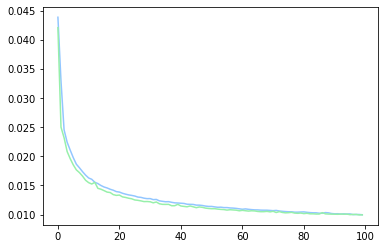

In [31]:
plt.plot(epoch_loss['train'])
plt.plot(epoch_loss['val'])

## test inference

### test on in-distribution examples

In [33]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

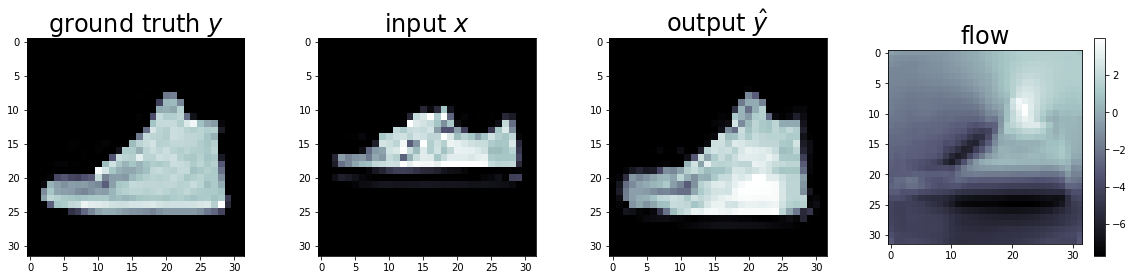

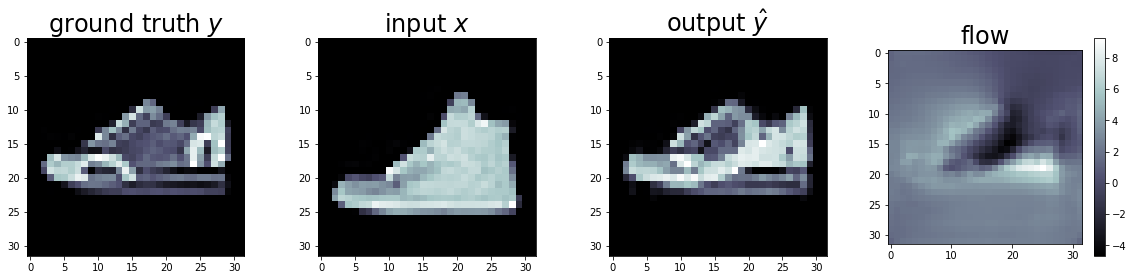

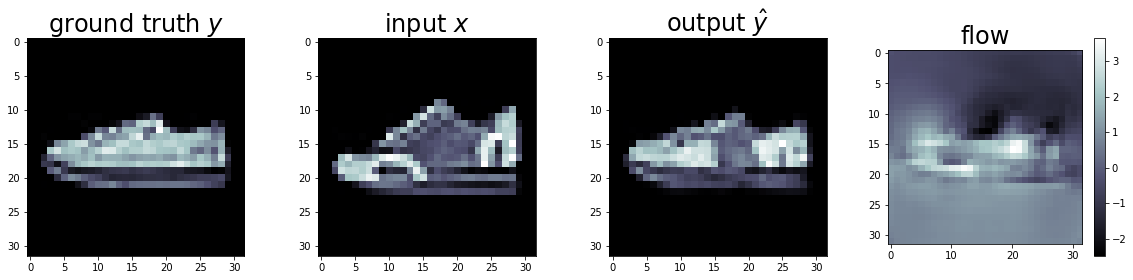

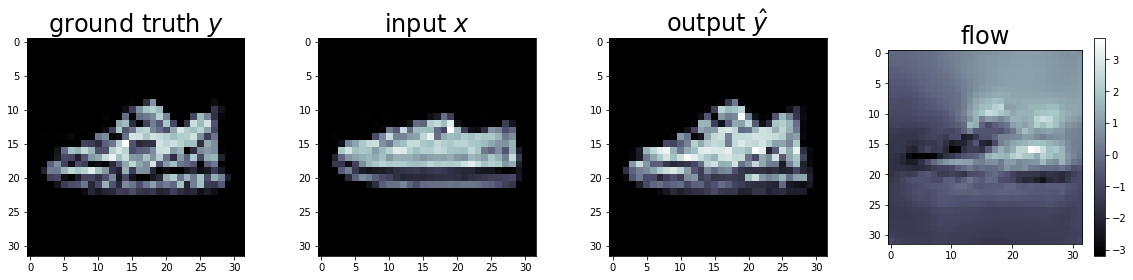

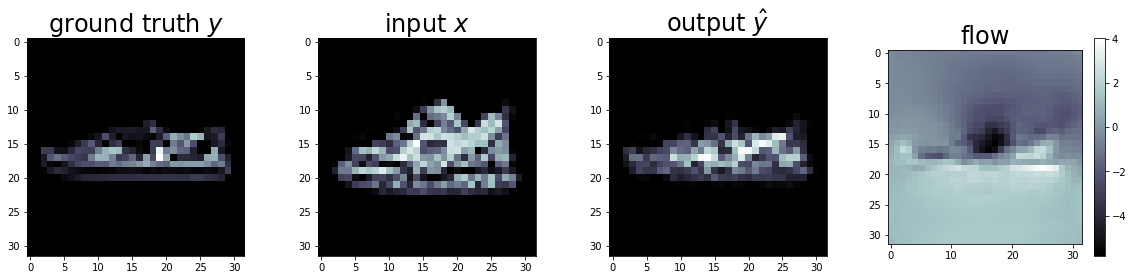

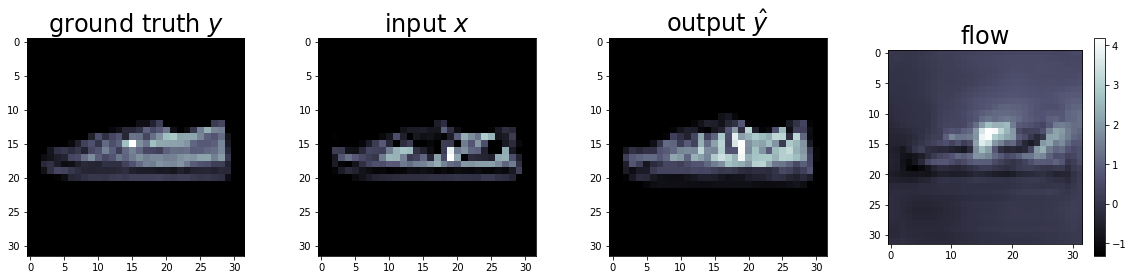

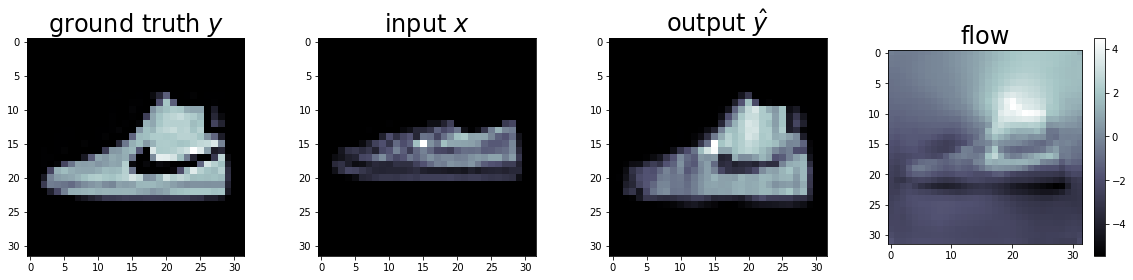

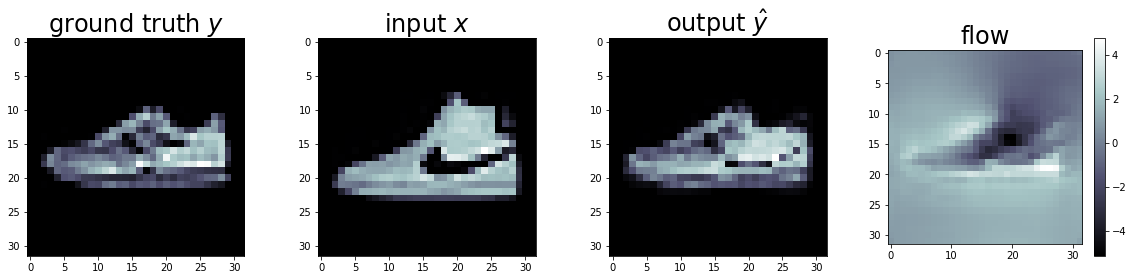

In [34]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'ground truth $y$', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'input $x$', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'output $\hat{y}$', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-sneaker-example-{k}.png')
    plt.show()

### test on out-of-distribution examples

In [41]:
test_dataset = sandal_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [42]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

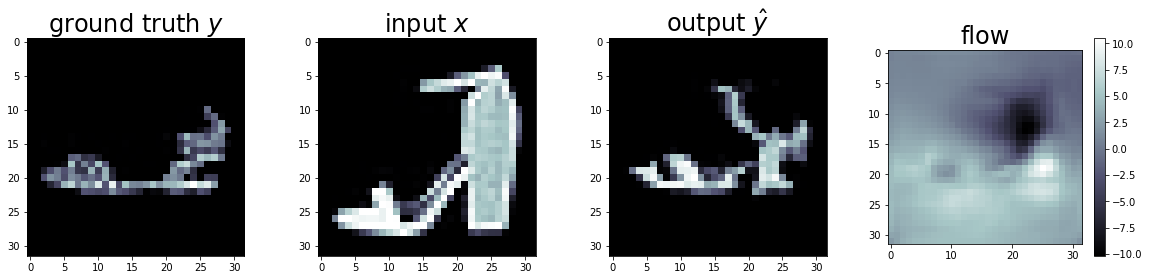

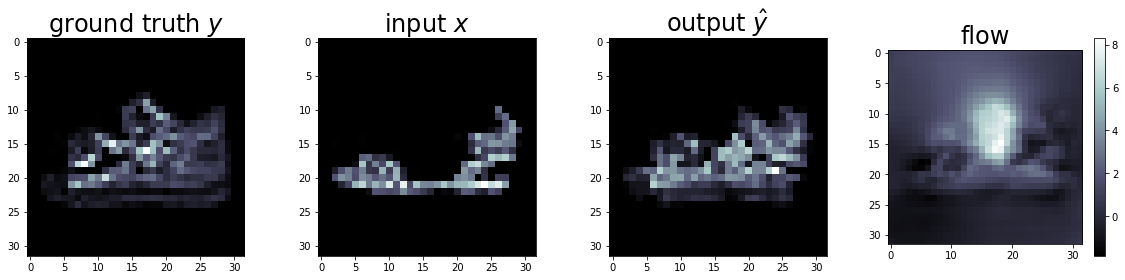

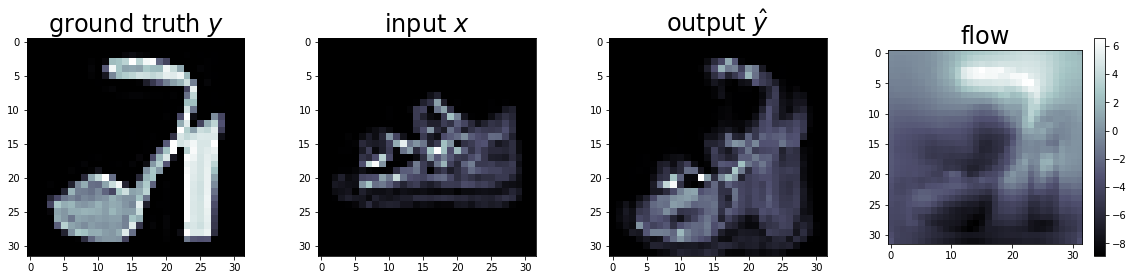

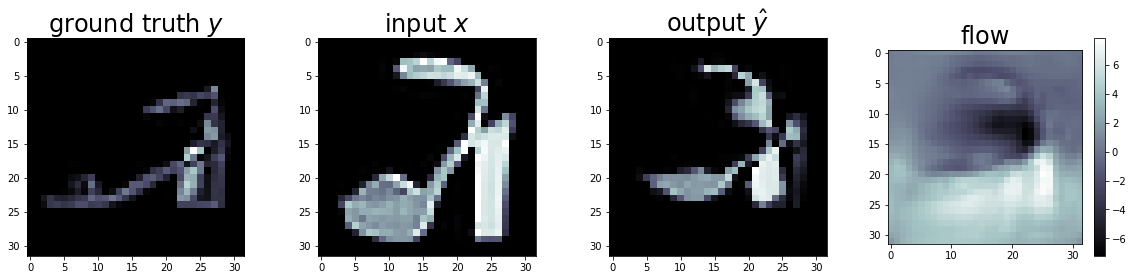

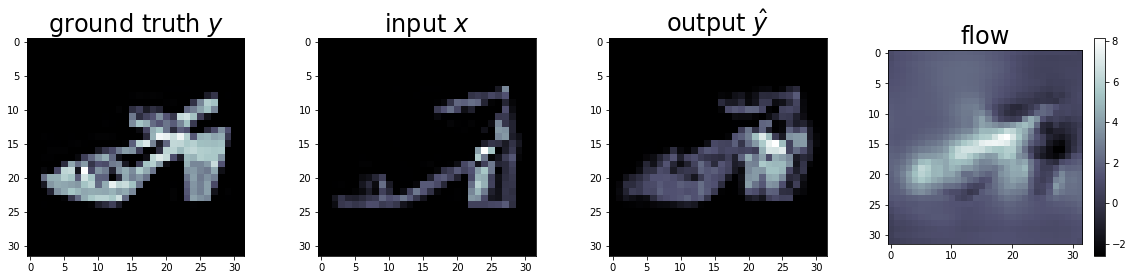

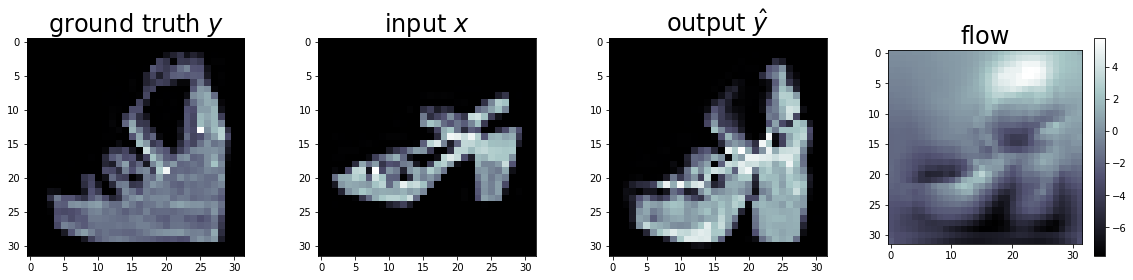

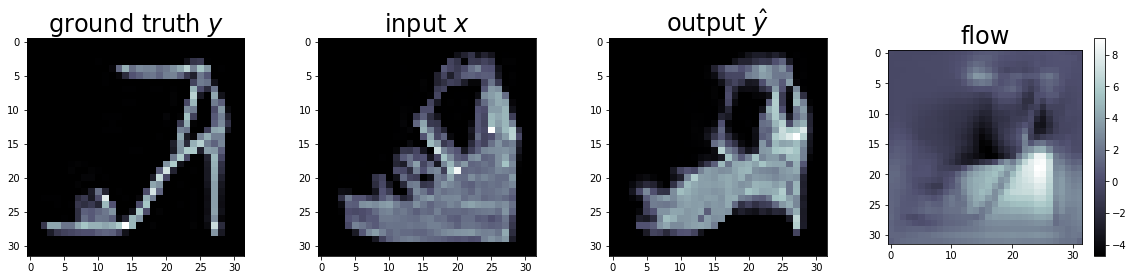

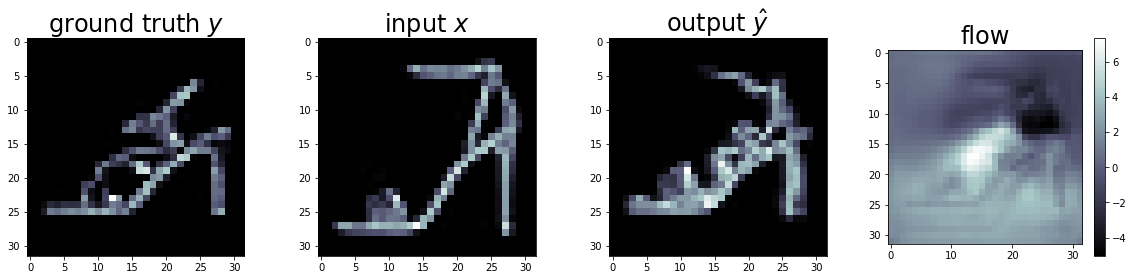

In [43]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'ground truth $y$', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'input $x$', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'output $\hat{y}$', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-sandal-example-{k}.png')
    plt.show()

In [44]:
test_dataset = boot_test_dataset
test_loader = get_dataloader(test_dataset, shuffle=False)

In [45]:
test_images = next(iter(test_loader)).to('cuda')
moved, warp = model(test_images)
test_images = test_images.cpu().detach().numpy()
moved = moved.cpu().detach().numpy()
warp = warp.cpu().detach().numpy()

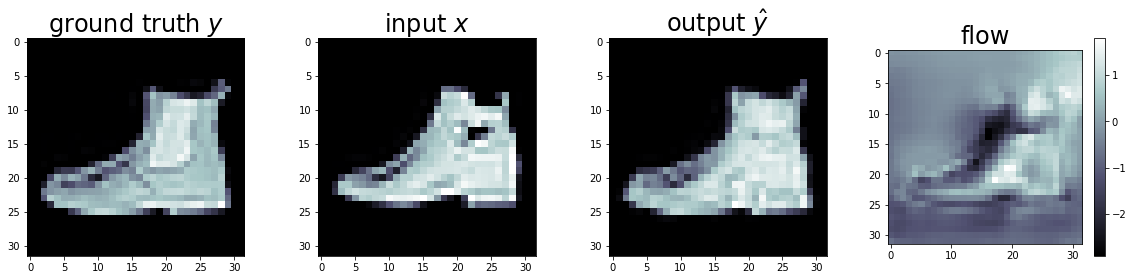

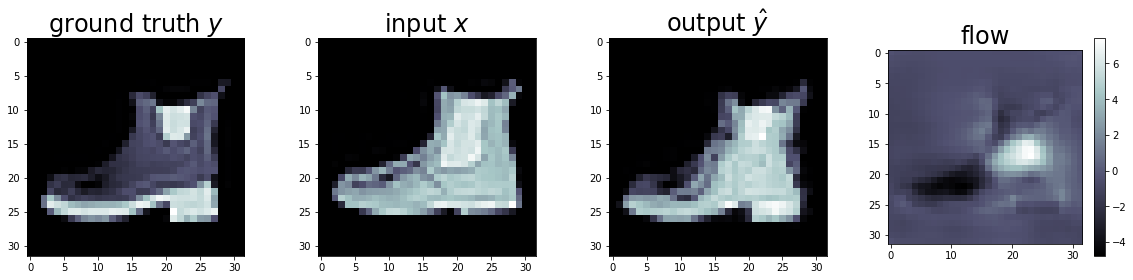

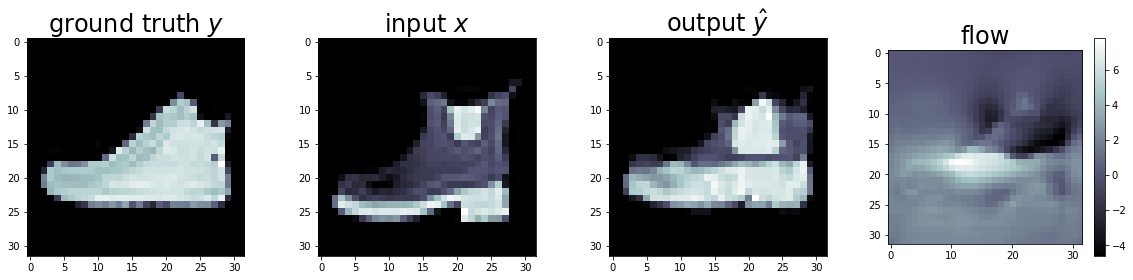

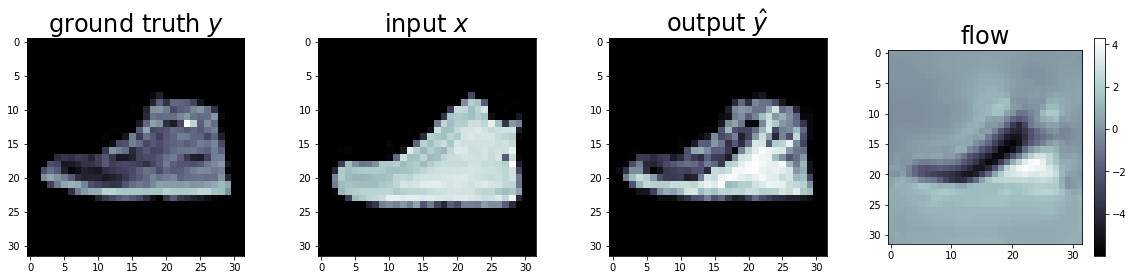

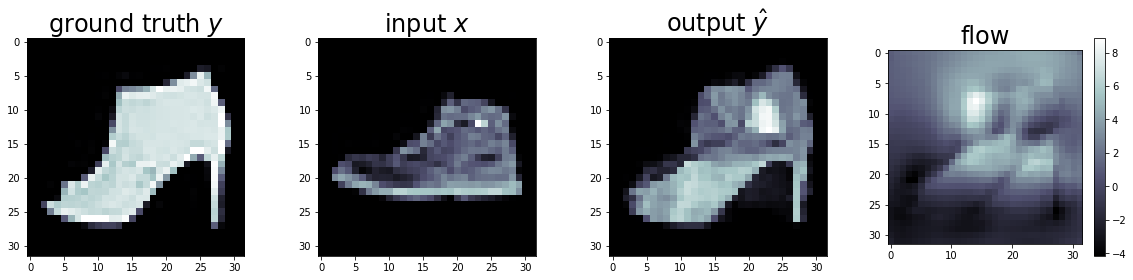

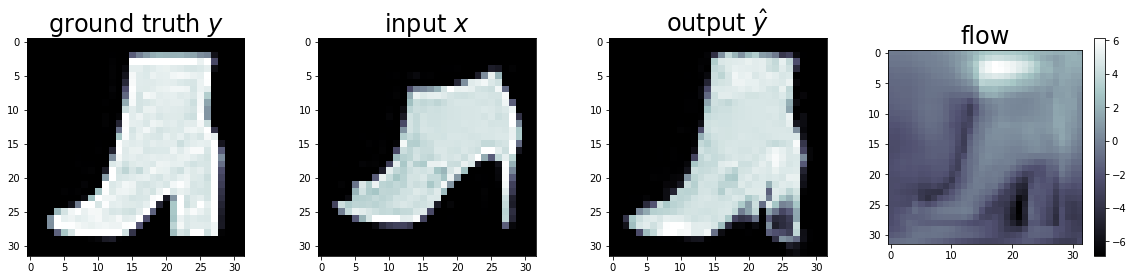

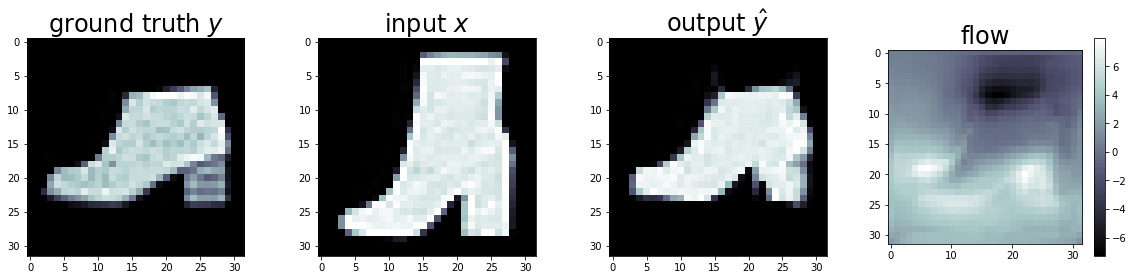

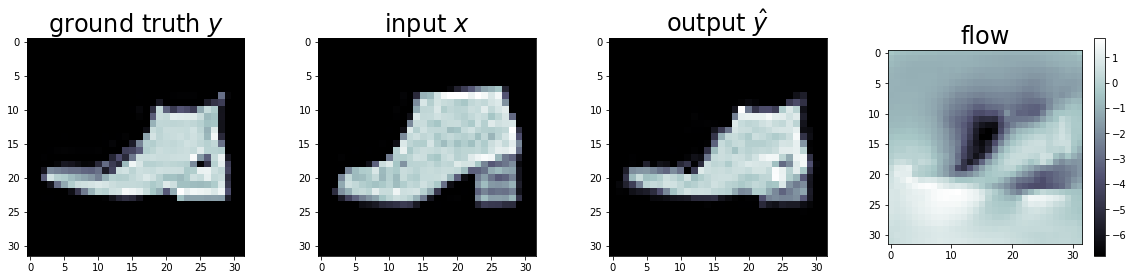

In [46]:
for k in range(8):
    fontsize=24
    cmap=plt.cm.bone
    moving, fixed = test_images[k, 0], test_images[k, 1]
    fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
    ax[0].imshow(fixed, cmap=cmap)
    ax[0].set_title(r'ground truth $y$', fontsize=fontsize)
    ax[1].imshow(moving, cmap=cmap)
    ax[1].set_title(r'input $x$', fontsize=fontsize)
    ax[2].imshow(moved[k, 0], cmap=cmap)
    ax[2].set_title(r'output $\hat{y}$', fontsize=fontsize)
    flow = ax[3].imshow(warp[k].sum(0), cmap=cmap)
    ax[3].set_title(r'flow', fontsize=fontsize)
    plt.colorbar(flow, ax=ax[3])
    plt.savefig(f'figures/voxelmorph-boot-example-{k}.png')
    plt.show()